<a href="https://colab.research.google.com/github/BiodataAnalysisGroup/PertFlow_A-cloud-based-workflow-for-scRNA-seq-perturbational-modeling/blob/main/PertFlow_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following Colab workflow represents **PertFlow**, a computational approach that enables basic scRNA-seq preprocessing with selected in silico tools for perturbational modeling and drug repurposing, using single-cell omics.

# **0.1 Set up GDrive working directory**

The first code chunks enables the user to designate a specific file in its Google Drive as working directory (e.g., here is My Drive/Colab Notebooks/Project_folder/CellMate_pilots).

In [ ]:
import os

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#set working directory

root_dir = "/content/drive/My Drive/"

In [ ]:
#choose the project folder
project_folder = "Colab Notebooks/Project_folder/CellMate_pilots/"
#project_folder = "Project_folder/"

In [ ]:
#define function to create and set working directory
def create_and_set_working_directory(project_folder):
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + 'did not exists and was created')

#change the OS path to project folder as working directory
os.chdir(root_dir + project_folder)

In [ ]:
!pwd

/content/drive/My Drive/Colab Notebooks/Project_folder/CellMate_pilots


# **0.2 Set up Rpy2 package for in tandem Python-R coding**

To enable interoperability between the Scanpy (Python) and Seurat (R) pipelines below, we activate the Rpy2 package

In [ ]:
!pip install rpy2==3.5.1 #https://stackoverflow.com/questions/74283327/conversion-py2rpy-not-defined-for-objects-of-type-class-str

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314920 sha256=f497a3b115f80d34ba9cc9e5e3ad825b91d0a26010b544e1e000c51656c15259
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.4.2
    Uninstalling rpy2-3.4.2:
      Successfully uninstalled rpy2-3.4.2


In [ ]:
%load_ext rpy2.ipython

In [ ]:
## To install packages from CRAN, just run the following code (always use %%R in the beginning of every code chunk!)
# %%R
# install.packages("")

In [ ]:
# # To install packages with devtools:
# %%bash
# # https://stackoverflow.com/questions/20923209/problems-installing-the-devtools-package
# sudo apt-get install libcurl4-openssl-dev libssl-dev libfontconfig1-dev libxml2-dev libharfbuzz-dev libfribidi-dev libfreetype6-dev libpng-dev libtiff5-dev libjpeg-dev

In [ ]:
# %%R
# library('devtools')

# **1. Scanpy basic preprocessing**

Scanpy is a scalable toolkit for analyzing single-cell gene expression data built jointly with anndata. It includes preprocessing, visualization, clustering, trajectory inference and differential expression testing. The Python-based implementation efficiently deals with datasets of more than one million cells. https://scanpy.readthedocs.io/en/stable/

In [ ]:
# https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html for an in-depth tutorial using PBMCs

In [ ]:
pip install scanpy

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc

In [ ]:
# sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_header()
# sc.settings.set_figure_params(dpi=80, facecolor='white')

In [ ]:
# results_file = 'write/name.h5ad'  # the file that will store the analysis results

In [ ]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading


In [ ]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata

**1.1 Pre-processing**

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [ ]:
sc.pp.log1p(adata)

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
adata.raw = adata

In [ ]:
adata = adata[:, adata.var.highly_variable]

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [ ]:
sc.pp.scale(adata, max_value=10)

**1.2 Principal component analysis**

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
sc.pl.pca(adata, color='CST3')

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
adata.write(results_file)
adata

**1.3 Computing the neighborhood graph**

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

**1.4 Embedding the neighborhood graph**

In [ ]:
sc.tl.umap(adata)


In [ ]:
sc.pl.umap(adata, color=['Gene1', 'Gene2', 'Gene3'])


In [ ]:
sc.pl.umap(adata, color=['Gene1', 'Gene2', 'Gene3'], use_raw=False)


**1.5 Clustering the neighborhood graph**

In [ ]:
sc.tl.leiden(adata)


In [ ]:
sc.pl.umap(adata, color=['Gene1', 'Gene2', 'Gene3'])


In [ ]:
adata.write(results_file)


In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)


In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity


In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
adata.write(results_file)


**1.6 Finding marker genes**

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
marker_genes = ['IL7R', 'CD79A', ...]

In [ ]:
adata = sc.read(results_file)


In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)


In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)


In [ ]:
adata = sc.read(results_file)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)


In [ ]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')


In [ ]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

In [ ]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')


In [ ]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');


In [ ]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);
adata


In [ ]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading


In [ ]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')


# **2. Pathway enrichment and transcription factor enrichment through decoupler**

**decoupler** is a package containing different statistical methods to extract biological activities from omics data within a unified framework. It allows to flexibly test any method with any prior knowledge resource and incorporates methods that take into account the sign and weight. It can be used with any omic, as long as its features can be linked to a biological process based on prior knowledge. For example, in transcriptomics gene sets regulated by a transcription factor, or in phospho-proteomics phosphosites that are targeted by a kinase.

PertFlow enables "Pathway activity inference" and "Transcription factor activity inference" but more utilities from Decoupler can be incorporated based on the user's specifications:

https://decoupler-py.readthedocs.io/en/latest/notebooks/progeny.html


https://decoupler-py.readthedocs.io/en/latest/notebooks/dorothea.html

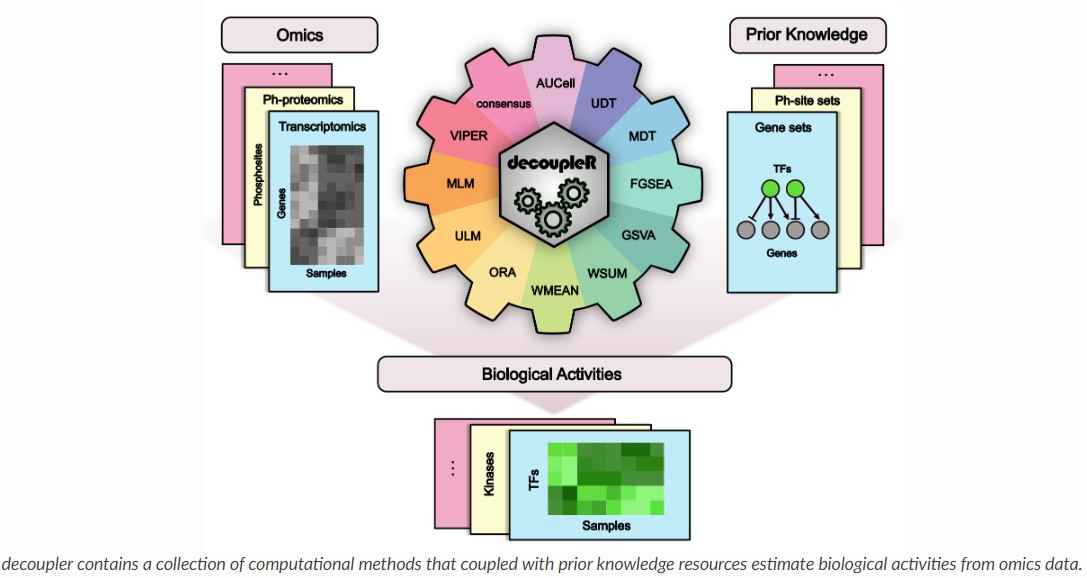

**2.1 Pathway activity inference**

scRNA-seq yield many molecular readouts that are hard to interpret by themselves. One way of summarizing this information is by infering pathway activities from prior knowledge.

In this notebook we showcase how to use decoupler for pathway activity inference with the 3k PBMCs 10X data-set. The data consists of 3k PBMCs from a Healthy Donor and is freely available from 10x Genomics here from this webpage

In [ ]:
import scanpy as sc
import decoupler as dc

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

In [ ]:
adata = sc.datasets.pbmc3k_processed()
adata

In [ ]:
sc.pl.umap(adata, color='louvain')

***PROGENy model***

PROGENy is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction. For this example we will use the human weights (other organisms are available) and we will use the top 500 responsive genes ranked by p-value. Here is a brief description of each pathway:

Androgen: involved in the growth and development of the male reproductive organs.

EGFR: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells

Estrogen: promotes the growth and development of the female reproductive organs.

Hypoxia: promotes angiogenesis and metabolic reprogramming when O2 levels are low.

JAK-STAT: involved in immunity, cell division, cell death, and tumor formation.

MAPK: integrates external signals and promotes cell growth and proliferation.

NFkB: regulates immune response, cytokine production and cell survival.

p53: regulates cell cycle, apoptosis, DNA repair and tumor suppression.

PI3K: promotes growth and proliferation.

TGFb: involved in development, homeostasis, and repair of most tissues.

TNFa: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.

Trail: induces apoptosis.

VEGF: mediates angiogenesis, vascular permeability, and cell migration.

WNT: regulates organ morphogenesis during development and tissue repair.

To access it we can use decoupler.

In [ ]:
progeny = dc.get_progeny(organism='human', top=500)
progeny

***Activity inference with multivariate linear model (MLM)***

To infer pathway enrichment scores we will run the multivariate linear model (mlm) method. For each cell in our dataset (adata), it fits a linear model that predicts the observed gene expression based on all pathways’ Pathway-Gene interactions weights. Once fitted, the obtained t-values of the slopes are the scores. If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.

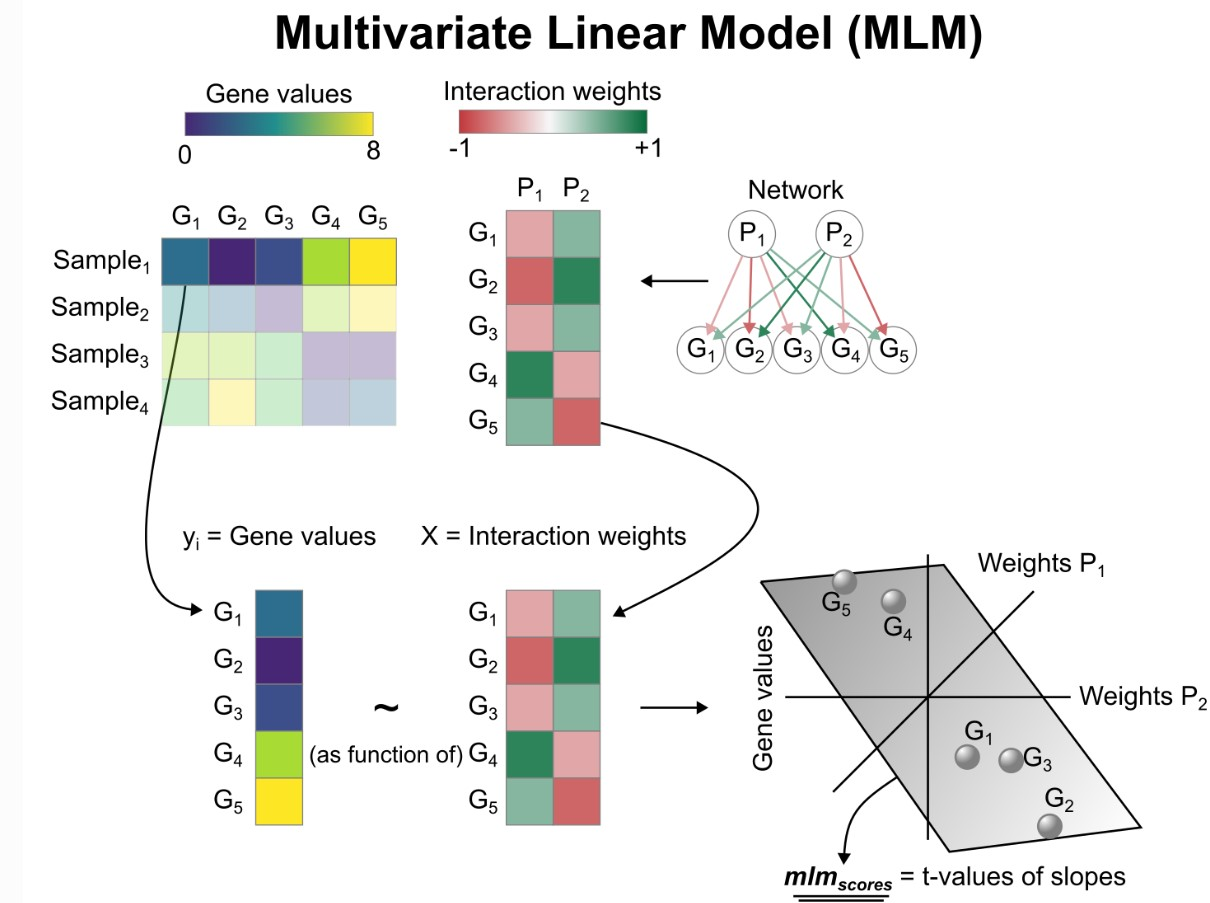

To run decoupler methods, we need an input matrix (mat), an input prior knowledge network/resource (net), and the name of the columns of net that we want to use.

In [ ]:
dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

**2.2 Transcription factor activity inference**

scRNA-seq yield many molecular readouts that are hard to interpret by themselves. One way of summarizing this information is by infering transcription factor (TF) activities from prior knowledge.

In this notebook we showcase how to use decoupler for TF activity inference with the 3k PBMCs 10X data-set. The data consists of 3k PBMCs from a Healthy Donor and is freely available from 10x Genomics here from this webpage

***CollecTRI network***

CollecTRI is a comprehensive resource containing a curated collection of TFs and their transcriptional targets compiled from 12 different resources. This collection provides an increased coverage of transcription factors and a superior performance in identifying perturbed TFs compared to our previous DoRothEA network and other literature based GRNs. Similar to DoRothEA, interactions are weighted by their mode of regulation (activation or inhibition).

For this example we will use the human version (mouse and rat are also available). We can use decoupler to retrieve it from omnipath. The argument split_complexes keeps complexes or splits them into subunits, by default we recommend to keep complexes together.

In [ ]:
net = dc.get_collectri(organism='human', split_complexes=False)
net

In this tutorial we use the network CollecTRI, but we could use any other GRN coming from an inference method such as CellOracle, pySCENIC or SCENIC+.

***Activity inference with univariate linear model (ULM)***

To infer TF enrichment scores we will run the univariate linear model (ulm) method. For each cell in our dataset (adata) and each TF in our network (net), it fits a linear model that predicts the observed gene expression based solely on the TF’s TF-Gene interaction weights. Once fitted, the obtained t-value of the slope is the score. If it is positive, we interpret that the TF is active and if it is negative we interpret that it is inactive.

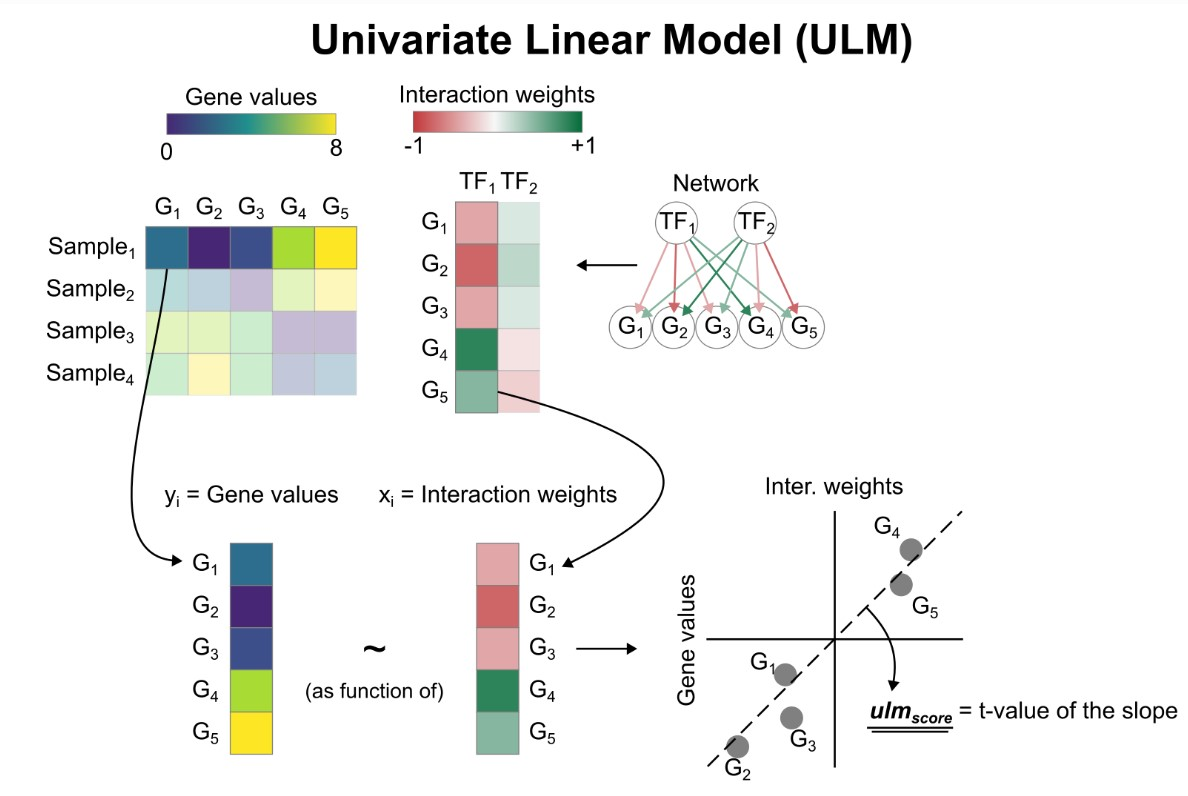

In [ ]:
dc.run_ulm(
    mat=adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

In [ ]:
adata.obsm['ulm_estimate']

In [ ]:
adata.obsm['collectri_ulm_estimate'] = adata.obsm['ulm_estimate'].copy()
adata.obsm['collectri_ulm_pvals'] = adata.obsm['ulm_pvals'].copy()
adata

***Visualization***

In [ ]:
acts = dc.get_acts(adata, obsm_key='ulm_estimate')

# We can scale the obtained activities for better visualizations
sc.pp.scale(acts)
acts

In [ ]:
sc.pl.umap(acts, color=['PAX5', 'louvain'], cmap='RdBu_r', vcenter=0)
sc.pl.violin(acts, keys=['PAX5'], groupby='louvain', rotation=90)

Here we observe the activity infered for PAX5 across cells, which it is particulary active in B cells. Interestingly, PAX5 is a known TF crucial for B cell identity and function. The inference of activities from “foot-prints” of target genes is more informative than just looking at the molecular readouts of a given TF, as an example here is the gene expression of PAX5, which is not very informative by itself since it is just expressed in few cells:

In [ ]:
sc.pl.umap(adata, color=['PAX5', 'louvain'])
sc.pl.violin(adata, keys=['PAX5'], groupby='louvain', rotation=90)

***Exploration***

Let’s identify which are the top TF per cell type. We can do it by using the function dc.rank_sources_groups, which identifies marker TFs using the same statistical tests available in scanpy’s scanpy.tl.rank_genes_groups.

In [ ]:
df = dc.rank_sources_groups(acts, groupby='louvain', reference='rest', method='t-test_overestim_var')
df

We can then extract the top 3 markers per cell type:

In [ ]:
n_markers = 3
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers

In [ ]:
sc.pl.matrixplot(acts, source_markers, 'louvain', dendrogram=True,
                 colorbar_title='Z-scaled scores', vmin=-2, vmax=2, cmap='RdBu_r')

Finally, we can check individual TFs by plotting their distributions:

In [ ]:
sc.pl.violin(acts, keys=['EBF1'], groupby='louvain', rotation=90)

# **3. PertPy toolkit for AugurPy, scGEN and Mixscape**

*PertPy* represents a core inspiration for **PertFlow** since it provides access to python iterations of Augur, Mixscape (otherwise also available in R) and for scGEN. The user is encouraged to deploy other PertPy tools in the PertFlow architecture for more nuanced results (https://pertpy.readthedocs.io/en/latest/).

In [ ]:
!pip install pertpy

In [ ]:
pip install lightning==2.0.1 # https://stackoverflow.com/questions/76647518/how-to-fix-error-cannot-import-name-modelmetaclass-from-pydantic-main

In [ ]:
pip install flax==0.7.0 # https://pypi.org/project/flax/#history

In [ ]:
import pertpy as pt

**2.1 AugurPy for cell-type prioritization**

Augur's objective (https://doi.org/10.1038/s41587-020-0605-1) is to rank or prioritize cell types based on their responses to experimental perturbations using high-dimensional single-cell sequencing data. It achieves this by assessing how effectively cells with strong reactions to perturbations can be distinguished from those with weak reactions in terms of molecular measurements. This separation ability is determined by the predictive accuracy of experimental labels (e.g., treatment vs. control) within each cell type. Augur trains machine learning models for each cell type through cross-validation, prioritizing cell types based on metric scores that gauge the model's accuracy. Categorical data uses the default area under the curve metric, while numerical data employs the concordance correlation coefficient as an approximation of perturbation response accuracy.

A tutorial illustrates Augur's usage with a simulated dataset containing 600 cells across three populations (cell types A, B, and C). These cell types are evenly split between treatment and control conditions, with varying proportions of differentially expressed genes in response to treatment: around 5% for cell type A, 25% for cell type B, and 50% for cell type C.
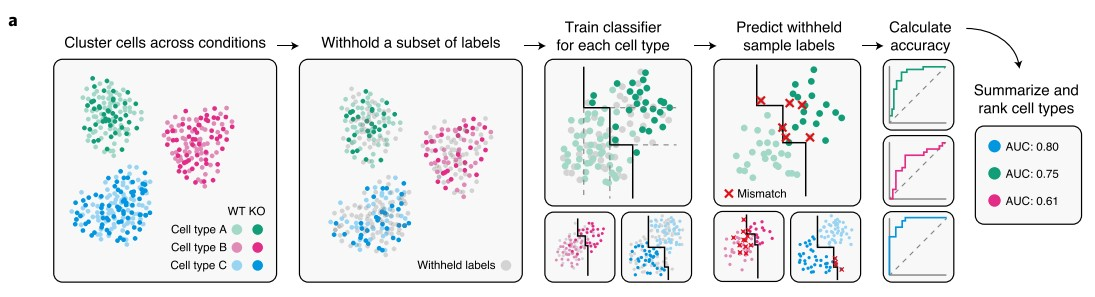

First we import the data that we want to work with. This can either be an anndata object, a dataframe containing cell type labels as well as conditions for each cell or data contained in a dataframe with corresponding meta data containing cell type labels and conditions.

Then, we create an Augur object from pertpy based on our estimator of interest to measure how predictable the perturbation labels for each cell type in the dataset are. Choose random_forest_classifier or logistic_regression_classifier for categorical data and random_forest_regressor for numerical data. Additional parameters can be added throught the Params class.

Next, load this data into an anndata object adding dummie variables of labels and renaming cell type and label observation columns to cell_type and label.
https://pertpy.readthedocs.io/en/latest/tutorials/notebooks/augur.html

In [ ]:
adata = pt.dt.kang_2018()

In [ ]:
#We rename label to condition and the conditions themselves for improved readability.
adata.obs.rename({"label": "condition"}, axis=1, inplace=True)
adata.obs["condition"].replace({"ctrl": "control", "stim": "stimulated"}, inplace=True)

In [ ]:
adata.obs.cell_type.value_counts()

In [ ]:
ag_rfc = pt.tl.Augur("random_forest_classifier")

In [ ]:
loaded_data = ag_rfc.load(adata, label_col="condition", cell_type_col="cell_type")
loaded_data

Then we run Augur with the function predict and look at the results.

In [ ]:
h_adata, h_results = ag_rfc.predict(loaded_data, subsample_size=20, n_threads=4)

print(h_results["summary_metrics"])

The default way to select features is based on scanpy.pp.highly_variable_genes. The results are shown above. In addition there is also the option of selecting features with select_variance activated by setting select_variance_features=True, an implementation that is very close to the original R Augur implementation.

In [ ]:
v_adata, v_results = ag_rfc.predict(
    loaded_data, subsample_size=20, n_threads=4, select_variance_features=True, span=1
)

v_results["summary_metrics"]

In [ ]:
lollipop = pt.pl.ag.lollipop(v_results)

Here we visualize the cell ranking and the corresponding augur scores using select variance feature selection in a lollipop plot. In this case the ranking it the same but the values themselves differ between the two methods.

The corresponding mean_augur_score is also saved in result_adata.obs and can be plotted in a UMAP.

In [ ]:
sc.pp.neighbors(v_adata)
sc.tl.umap(v_adata)

In [ ]:
sc.pl.umap(adata=v_adata, color=["augur_score", "cell_type", "label"])

The results object also returns feature importances. In the case of a random forest estimator the feature importances built into sci-kit learn were used as feature importances. For the logistic regression the agresti method was used (as in the R library Augur). This means the mean was subtracted from the coefficient values and then divided by the standard deviation.

In [ ]:
important_features = pt.pl.ag.important_features(v_results)

**2.2 scGEN for perturbational modeling**

scGen (https://doi.org/10.1038/s41592-019-0494-8), a model combining variational autoencoders and latent space vector arithmetics for high-dimensional
single-cell gene expression data. scGen accurately models perturbation  response of cells across cell types, studies and species.
This tutorial reproduces https://scgen.readthedocs.io/en/stable/tutorials/scgen_perturbation_prediction.html with PertPy's custom Jax implementation.

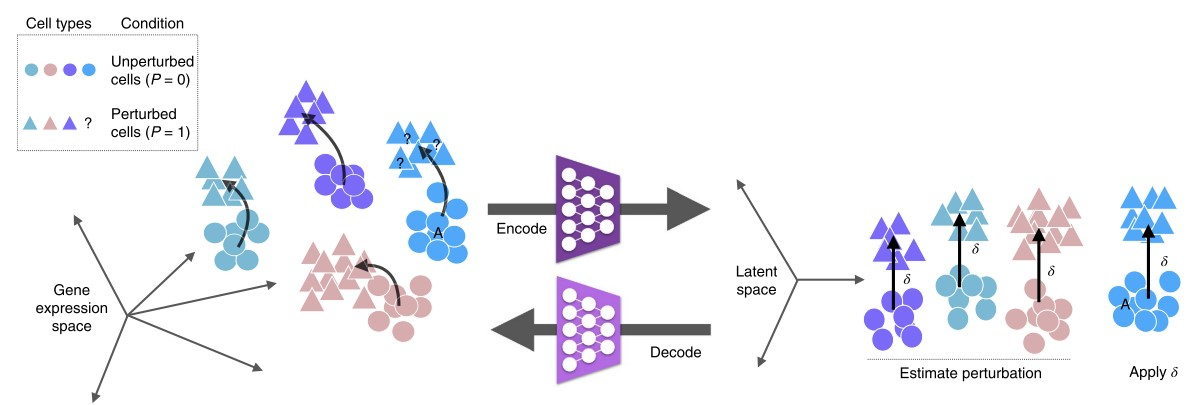

In [ ]:
# ! pip install pertpy
# ! pip install protobuf==4.23.2

In [ ]:
# import scanpy as sc

In [ ]:
from scvi import REGISTRY_KEYS

2.2.1 Loading the data

In [ ]:
train = sc.read("./tests/data/train_kang.h5ad",
                backup_url='https://drive.google.com/uc?id=1r87vhoLLq6PXAYdmyyd89zG90eJOFYLk')

In [ ]:
train.obs

In [ ]:
train_new = train[~((train.obs["cell_type"] == "CD4T") &
                    (train.obs["condition"] == "stimulated"))]

In [ ]:
train_new = train_new.copy()

2.2.2 Pre-processing the data

In [ ]:
pt.tl.SCGEN.setup_anndata(train_new, batch_key="condition", labels_key="cell_type")

2.2.3 Creating the model

In [ ]:
model = pt.tl.SCGEN(train_new)

2.2.4 Training the model

In [ ]:
model.train(
    max_epochs=1,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25
)

In [ ]:
model.save("saved_models/model_perturbation_prediction.pt", overwrite=True)

2.2.5 Latent space

In [ ]:
latent_X = model.get_latent_representation()
latent_adata = sc.AnnData(X=latent_X, obs=train_new.obs.copy())

In [ ]:
sc.pp.neighbors(latent_adata)

In [ ]:
sc.tl.umap(latent_adata)

In [ ]:
sc.pl.umap(latent_adata, color=['condition', 'cell_type'], wspace=0.4, frameon=False,
           save='latentspace_batch32_klw000005_z100__100e.pdf')

2.2.6 Prediction

After training the model you can pass the adata of the cells you want to perturb. Here we pass unperturbed CD4T cells

Here the AnnData object contains the cells that you want estimate the perturbation based on them. we set “ctrl” to our control labels and “stim” to our stimulated labels. If you apply it in another context just set “ctrl” :”your_control_label” and “stim”:”your_stimulated_label”. the returned value is a numpy matrix of our predicted cells and the second one is the difference vector between our conditions which might become useful later.

In [ ]:
pred, delta = model.predict(
    ctrl_key='control',
    stim_key='stimulated',
    celltype_to_predict='CD4T'
)
pred.obs['condition'] = 'pred'

In the previous block, the difference between conditions is by default computed using all cells (obs_key=”all”). However, some times you might have a rough idea that which groups (e.g. cell types) are close to your cell type of interest. This might give you more accurate predictions. For example, we can restrict the delta computation only to CD8T and NK cells. We provide dictionary in form of obs_key={“cell_type”: [“CD8T”, “NK”]} which is telling the model to look at “cell_type” labels in adata (here: train_new) and only compute the delta vector based on “CD8T” and “NK” cells :

pred, delta = pt.tl.SCGEN.predict(adata=train_new, adata_to_predict=unperturbed_cd4t, conditions={“ctrl”: “control”, “stim”: “stimulated”}, cell_type_key=”cell_type”, condition_key=”condition”, obs_key={“cell_type”: [“CD8T”, “NK”]})`

2.2.7 Evaluation of the prediction:
Extracting both control and real stimulated CD4T cells from our dataset

In [ ]:
ctrl_adata = train[((train.obs['cell_type'] == 'CD4T') & (train.obs['condition'] == 'control'))]
stim_adata = train[((train.obs['cell_type'] == 'CD4T') & (train.obs['condition'] == 'stimulated'))]

In [ ]:
eval_adata = ctrl_adata.concatenate(stim_adata, pred)

2.2.8 Embedding all real and predicted cells in one PCA plot

In [ ]:
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color="condition", frameon=False,
           save='pred_stim_b32_klw000005_z100__100e.pdf')

2.2.9 Mean correlation plot

In [ ]:
CD4T = train[train.obs["cell_type"] =="CD4T"]

In [ ]:
sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["stimulated"]
print(diff_genes)

In [ ]:
condition_key = model.adata_manager.get_state_registry(
    REGISTRY_KEYS.BATCH_KEY).original_key

r2_value = pt.pl.scg.reg_mean_plot(
    eval_adata,
    condition_key=condition_key,
    axis_keys={"x": "pred", "y": "stimulated"},
    gene_list=diff_genes[:10],
    labels={"x": "predicted", "y": "ground truth"},
    path_to_save="./reg_mean1.pdf",
    show=True,
    legend=False
)

In [ ]:
r2_value = pt.pl.scg.reg_mean_plot(
    eval_adata,
    condition_key=condition_key,
    axis_keys={"x": "pred", "y": "stimulated"},
    gene_list=diff_genes[:10],
    top_100_genes= diff_genes,
    labels={"x": "predicted","y": "ground truth"},
    path_to_save="./reg_mean1.pdf",
    show=True,
    legend=False
)

2.2.10
Violin plot for a specific gene

In [ ]:
sc.pl.violin(eval_adata, keys="ISG15", groupby="condition")

**2.3 Mixscape - analysis of single-cell pooled CRSIPR screen**

In [ ]:
# https://pertpy.readthedocs.io/en/latest/tutorials/notebooks/mixscape.html

This vignette reproduces the Mixscape https://satijalab.org/seurat/articles/mixscape_vignette.html .


Mixscape leverages CRISPR-compatible (EC)CITE-seq, a technology that combines pooled CRISPR screens with single-cell mRNA and surface protein measurements, to explore the molecular networks that regulate PD-L1 expression. Mixscape improves the signal-to-noise ratio in single-cell perturbation screens by identifying and removing confounding sources of variation.

***Mixscape can reveal the perturbational landscape after molecular knockdowns, hence an assessment can be made whether a particular target is "druggable" for a specific disease context.***


Reference: Papalexi, E., Mimitou, E.P., Butler, A.W. et al. Characterizing the molecular regulation of inhibitory immune checkpoints with multimodal single-cell screens. Nat Genet 53, 322–331 (2021). https://doi.org/10.1038/s41588-021-00778-2



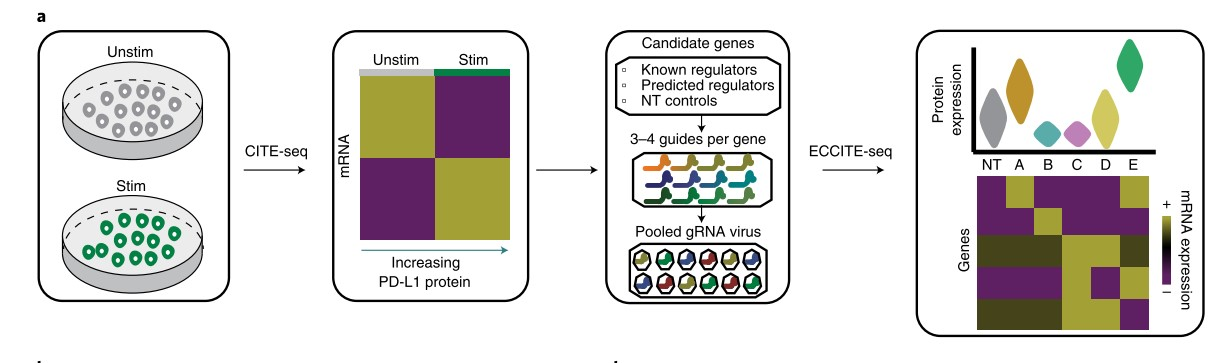

In [ ]:
import muon as mu
import pandas as pd

2.3.1 Getting the dataset

Download a 111 gRNA ECCITE-seq dataset generated from stimulated THP-1 cells that was published in bioRxiv https://www.biorxiv.org/content/10.1101/2020.06.28.175596v1

In [ ]:
mdata = pt.dt.papalexi_2021()

In [ ]:
mdata

In [ ]:
#  non-perturbed (NP) cells
#  cells expressing non-targeting gRNAs (NT)

2.3.2 Pre-processing

In [ ]:
# Preprocessing - RNA layer
mdata["rna"]
sc.pp.normalize_total(mdata['rna'])
sc.pp.log1p(mdata['rna'])
sc.pp.highly_variable_genes(mdata['rna'], subset=True)

In [ ]:
# Preprocessing - Protein layer
mdata["adt"]
mu.prot.pp.clr(mdata["adt"])

2.3.3 RNA-based clustering is driven by confounding sources of variation

Cluster cells based on their gene expression profiles. We expect perturbation-specific clusters, but as we can see, from the UMAP plots, the clustering is primarily driven by cell cycle phase and replicate ID.

In [ ]:
# RNA-based clustering is driven by confounding sources of variation
sc.pp.pca(mdata["rna"])
sc.pp.neighbors(mdata['rna'], metric='cosine')
sc.tl.umap(mdata["rna"])
sc.pl.umap(mdata["rna"], color=["replicate", "Phase", "perturbation"])

2.3.4 Calculating local perturbation signatures mitigates confounding effects

Calculate perturbation signature. For each cell, we identify n_neighbors cells from the control pool with the most similar mRNA expression profiles. The perturbation signature is calculated by subtracting the averaged mRNA expression profile of the control neighbors from the mRNA expression profile of each cell.

In [ ]:
# Calculating local perturbation signatures mitigates confounding effects
mixscape_identifier = pt.tl.Mixscape()
mixscape_identifier.perturbation_signature(mdata['rna'], 'perturbation', 'NT', 'replicate')

adata_pert = mdata['rna'].copy()

adata_pert.X = adata_pert.layers['X_pert']

sc.pp.pca(adata_pert)
sc.pp.neighbors(adata_pert, metric='cosine')
sc.tl.umap(adata_pert)
sc.pl.umap(adata_pert, color=['replicate', 'Phase', 'perturbation'])

2.3.5 Mixscape identifies cells with no detectable perturbation

Identify perturbed and non-perturbed gRNA expressing cells that accounts for multiple perturbations.

In [ ]:
# Mixscape identifies cells with no detectable perturbation
mixscape_identifier.mixscape(adata = mdata['rna'], control = 'NT', labels='gene_target', layer='X_pert')

pt.pl.ms.barplot(mdata['rna'], guide_rna_column='NT', axis_text_x_size=12, axis_text_y_size=10)

2.3.6 Inspecting mixscape results

Explore the perturbation scores of cells.

In [ ]:
# Inspecting mixscape results
pt.pl.ms.perturbscore(adata = mdata['rna'], labels='gene_target', target_gene='IFNGR2', color = 'orange')

In [ ]:
pt.pl.ms.violin(adata = mdata['rna'], target_gene_idents=['NT', 'IFNGR2 NP', 'IFNGR2 KO'], groupby='mixscape_class')

In [ ]:
pt.pl.ms.heatmap(adata = mdata['rna'], labels='gene_target', target_gene='IFNGR2', layer='X_pert', control='NT')

In [ ]:
mdata['adt'].obs['mixscape_class_global'] = mdata['rna'].obs['mixscape_class_global']
pt.pl.ms.violin(adata = mdata['adt'], target_gene_idents=["NT","JAK2","STAT1","IFNGR1","IFNGR2", "IRF1"], keys='PDL1', groupby='gene_target', hue='mixscape_class_global')

2.3.7 Visualizing perturbation responses with Linear Discriminant Analysis (LDA)

Use LDA as a dimensionality reduction method to visualize perturbation-specific clusters. LDA is trying to maximize the separability of known labels (mixscape classes) using both gene expression and the labels as input.

In [ ]:
mixscape_identifier = pt.tl.Mixscape()
mixscape_identifier.lda(adata=mdata['rna'], control='NT', labels='gene_target', layer='X_pert')

pt.pl.ms.lda(adata=mdata['rna'], control='NT')

# **4. More complex Deep Learning for perturbations: CPA - Compositional Perturbation Autoencoder**

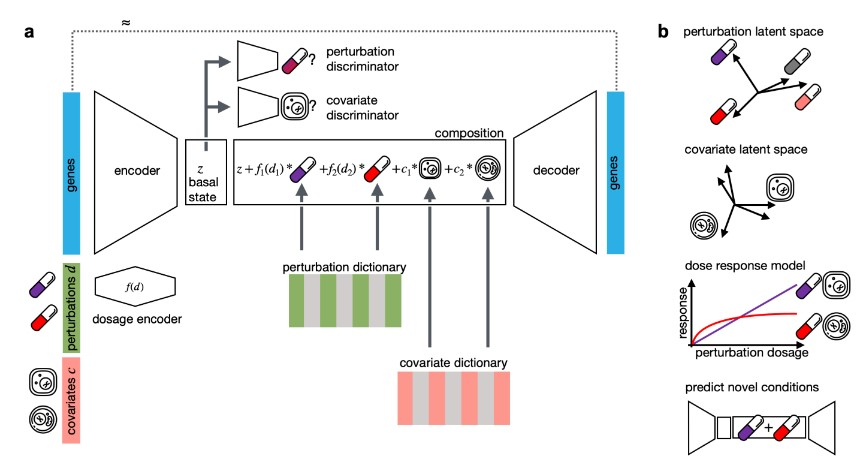

CPA (https://doi.org/10.15252/msb.202211517) is a framework to learn effects of perturbations at the single-cell level. CPA encodes and learns phenotypic drug response across different cell types, doses and drug combinations. CPA allows:

(1) Out-of-distribution predicitons of unseen drug combinations at various doses and among different cell types, (2)
Learn interpretable drug and cell type latent spaces, (3)
Estimate dose response curve for each perturbation and their combinations, (4)
Access the uncertainty of the estimations of the model.

https://github.com/facebookresearch/CPA

The following tutorial focuses on the application of CPA on the **sci-Plex assay** (profiles thousands of independent perturbations in a single experiment via nuclear hashing. With this high-throughput screen, 188 compounds were tested in three cancer cell lines).

The screened cell lines A549 (lung adenocarcinoma), K562 (chronic myelogenous leukemia), and MCF7 (mammary adenocarcinoma) were exposed to each of these 188 compounds at four doses (10 nM, 100 nM, 1 μM, 10 μM), and scRNA-seq profiles were generated for altogether 290 thousand cells.

In [ ]:
pip install git+https://github.com/facebookresearch/CPA.git

In [ ]:
from cpa.api import API

In [ ]:
from cpa.plotting import CPAVisuals

In [ ]:
# some standard packages to assist this tutorial
import cpa
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import os

%load_ext autoreload
%autoreload 2

Data Loading

In [ ]:
adata = sc.read("GSM_new.h5ad")

In [ ]:
adata

In [ ]:
adata.obs

Data Preparation

In [ ]:
cpa_api = cpa.api.API(
    adata,
    perturbation_key='condition',
    doser_type='logsigm',
    split_key='split',
    covariate_keys=["cell_type"],
    only_parameters=False,
    dose_key='dose_val',
    hparams={},
)

In [ ]:
adata.obs

In [ ]:
cpa_api.model

Start training

In [ ]:
cpa_api.train(
    max_epochs=500,
    run_eval=True,
    checkpoint_freq=20,
    filename=None,
    max_minutes=2*60
)

Visualize training history

In [ ]:
from cpa.plotting import CPAHistory
pretty_history = CPAHistory(cpa_api)
pretty_history.print_time()
pretty_history.plot_losses()
pretty_history.plot_r2_metrics(epoch_min=0)
pretty_history.plot_disentanglement_metrics(epoch_min=0)

In [ ]:
perts_anndata = cpa_api.get_drug_embeddings()
perts_anndata

Print and plot covars embeddings.

In [ ]:
covars_anndata = cpa_api.get_covars_embeddings(covars_tgt='cell_type')
covars_anndata

In [ ]:
cpa_api.compute_comb_emb(thrh=0)
cpa_api.compute_uncertainty(
                    cov={'cell_type': 'A549'},
                    pert='Nutlin',
                    dose='1.0'
                )

In [ ]:
cpa_plots = cpa.plotting.CPAVisuals(cpa_api, fileprefix=None)

In [ ]:
cpa_plots.plot_latent_embeddings(cpa_api.emb_perts, kind='perturbations', show_text=True)

In [ ]:
cpa_plots.plot_latent_embeddings(cpa_api.emb_perts + covars_anndata.X, kind='perturbations', show_text=True)

In [ ]:
perts_palette = {'BMS': '#999999',
                 'SAHA': '#4daf4a',
                 'Dex': '#377eb8',
                 'Nutlin': '#e41a1c',
                 'Vehicle': '#000000'

                }

cpa_plots.perts_palette = perts_palette
cpa_plots.plot_latent_embeddings(cpa_api.emb_perts, kind='perturbations', show_text=True)
cpa_plots.plot_latent_embeddings(cpa_api.emb_perts + covars_anndata.X, kind='perturbations', show_text=True)

In [ ]:
cpa_plots.plot_latent_embeddings(list(cpa_api.emb_covars['cell_type'].values()), kind='cell_type')

In [ ]:
latent_response = cpa_api.latent_dose_response(perturbations=None)
cpa_plots.plot_contvar_response(
    latent_response,
    postfix='latent',
    var_name=cpa_api.perturbation_key,
    title_name='Latent dose response')

In [ ]:
perturbations_pair = ['Nutlin', 'BMS']
latent_dose_2D = cpa_api.latent_dose_response2D(perturbations_pair, n_points=100)
cpa_plots.plot_contvar_response2D(latent_dose_2D,
        title_name='Latent dose-response')

In [ ]:
%%time

reconstructed_response2D = cpa_api.get_response2D(
    perturbations=perturbations_pair,
    covar={'cell_type': ['A549']}
)


cpa_plots.plot_contvar_response2D(
    reconstructed_response2D,
    title_name='Reconstructed dose-response  2D',
    logdose=False,
    # xlims=(-3, 0), ylims=(-3, 0)
    )

cpa_plots.plot_contvar_response2D(
    reconstructed_response2D,
    title_name='Reconstructed log10-dose-response 2D',
    logdose=True,
    xlims=(-3, 0), ylims=(-3, 0)
    )

In [ ]:
# %%time
df_reference = cpa_api.get_response_reference()

In [ ]:
# %%time
reconstructed_response = cpa_api.get_response(n_points=100)

You can plot an average response (saved under "response" column) among all genes, however, we don't consider it to be a good metric and strongly advise to look at the individual response among DE genes.

Solid lines in this plot correspond to the model predictions, dashed lines -- linear interpolations between measured points. Dots represent measured points, their color is proportional to the number of cells in this condition. Black dots represent points used in training and red dots correspond to the out-of-distribution examples.

In [ ]:
df_reference = df_reference.replace('training_treated', 'train')
cpa_plots.plot_contvar_response(
    reconstructed_response,
    df_ref=df_reference,
    postfix='reconstructed',
    title_name='Reconstructed dose response')

For example we can take of the top 50 DE genes for Nutlin - MDM2. MDM2 is itself transcriptionally-regulated by p53. And p53 is the target of Nutlin. Therefore, we expect our model to learn it.

In [ ]:
cpa_plots.plot_contvar_response(
    reconstructed_response,
    df_ref=df_reference,
    response_name='MDM2',
    postfix='MDM2',
    title_name='Reconstructed dose response of MDM2')

We can also look at this plot on the log10-scale. It makes sense for this dataset, because the measured doses were not evenly distributed.

In [ ]:
cpa_plots.plot_contvar_response(
    reconstructed_response,
    df_ref=df_reference,
    response_name='MDM2',
    postfix='MDM2',
    logdose=True,
    title_name='Reconstructed log10-dose response of MDM2')

**Predictions**

In [ ]:
print('Perturbations:', cpa_api.unique_perts)
print('Covariates:', cpa_api.unique_covars)
print('Datasets splits:', cpa_api.datasets.keys())

We can chose control cells from which we want to make our predictions. It is easy to chose these cells from either training or test splits.

In [ ]:
genes_control = cpa_api.datasets['test'].subset_condition(control=True).genes

By default, the prediction function returns means and variances of the applied perturbations.

In [ ]:
%%time
anndata_predicted = cpa_api.predict(
    genes_control,
    cov={'cell_type': ['A549', 'A549']},
    pert=['BMS', 'Dex'],
    dose=['1.0', '1.0'],
    return_anndata=True,
    sample=False
)

However, in some cases you want to sample from this distribution, so you can explicitly specify it in the predict function.

In [ ]:
%%time
anndata_predicted_samples = cpa_api.predict(
    genes_control,
    cov={'cell_type': ['A549', 'A549']},
    pert=['BMS', 'Dex'],
    dose=['1.0', '1.0'],
    return_anndata=True,
    sample=False,
    n_samples=10
)

Evaluation

In [ ]:
genes_control = cpa_api.datasets['training'].subset_condition(control=True).genes
df_train = cpa_api.evaluate_r2(cpa_api.datasets['training'].subset_condition(control=False), genes_control)
df_train['benchmark'] = 'CPA'

In [ ]:
genes_control = cpa_api.datasets['test'].subset_condition(control=True).genes
df_ood = cpa_api.evaluate_r2(cpa_api.datasets['ood'], genes_control)
df_ood['benchmark'] = 'CPA'

In [ ]:
genes_control = cpa_api.datasets['test'].subset_condition(control=True).genes
df_test = cpa_api.evaluate_r2(cpa_api.datasets['test'].subset_condition(control=False), genes_control)
df_test['benchmark'] = 'CPA'

In [ ]:
df_test = cpa_api.evaluate_r2(cpa_api.datasets['test'].subset_condition(control=False), genes_control)
df_test['benchmark'] = 'CPA'

In [ ]:
df_ood['split'] = 'ood'
df_test['split'] ='test'
df_train['split'] ='train'

In [ ]:
df_score = pd.concat([df_train, df_test, df_ood])
df_score.round(2).sort_values(by=['condition', 'R2_mean', 'R2_mean_DE'], ascending=False)

In [ ]:
cols_print = ['condition', 'dose_val','R2_mean', 'R2_mean_DE', 'R2_var', 'R2_var_DE', 'split', 'num_cells']
df_score = df_score.round(2).sort_values(by=['condition', 'R2_mean', 'R2_mean_DE'], ascending=False)
print(df_score[cols_print])
# print(df_score[cols_print].to_latex(index=False))

Uncertainty

We can profile all the predictions with an uncertainty score. Low uncertainty means "good/trustworthy" predictions, high values mean "bad/unknown quality" predictions.

In [ ]:
cpa_api.measured_points['all']

In [ ]:
import cpa.plotting as pl

for drug in ['Nutlin', 'BMS', 'Dex', 'SAHA']:
    df_pred = pl.plot_uncertainty_dose(
        cpa_api,
        cov={'cell_type': 'A549'},
        pert=drug,
        N=51,
        measured_points=cpa_api.measured_points['all'],
        cond_key='condition',
        log=True,
        metric='eucl'
    )

Previously, we demonstrated CPA predictions for drugs combinations. But our training data didn't contain any combinations examples. How much can we trust these examples? We can try to asses by running model uncertainty predictions:

In [ ]:
df_pred2D = pl.plot_uncertainty_comb_dose(
    cpa_api=cpa_api,
    cov={'cell_type': 'A549'},
    pert='Nutlin+BMS',
    N=51,
    cond_key='treatment',
    metric='eucl',
)

And here is the predicted response we plotted before:

In [ ]:
cpa_plots.plot_contvar_response2D(
    reconstructed_response2D,
    title_name='Reconstructed dose-response',
    logdose=False)

# **5. Drug Repurposing based on ASGARD through L1000 LINCS project**

4. AnnData to Seurat converter

In [ ]:
%R version[['version.string']]

In [ ]:
%R install.packages('Seurat')

In [ ]:
from scipy import io

In [ ]:
adata = adata.raw.to_adata() # if raw data needed

In [ ]:
!mkdir matrix_files

In [ ]:
with open('matrix_files/barcodes.tsv', 'w') as f:
    for item in adata.obs_names:
        f.write(item + '\n')

with open('matrix_files/features.tsv', 'w') as f:
    for item in ['\t'.join([x,x,'Gene Expression']) for x in adata.var_names]:
        f.write(item + '\n')

io.mmwrite('matrix_files/matrix', adata.X.T)

!ls matrix_files/

In [ ]:
!gzip matrix_files/*
!ls matrix_files/

In [ ]:
adata.obs.to_csv('metadata.csv')

In [ ]:
%R Raw_data <- Seurat::Read10X(data.dir = 'matrix_files')
#, gene.column = 2, cell.column = 1, strip.suffix=FALSE)

In [ ]:
%R rownames(metadata) <- metadata$index #the column name of the barcodes column -- watch the youtube video carefully

In [ ]:
adata.obs

In [ ]:
%R metadata

In [ ]:
%R sobj <- CreateSeuratObject(counts = Raw_data, meta.data = metadata)

In [ ]:
%R install.packages("reticulate")

In [ ]:
%R library(reticulate)

In [ ]:
%R metadata <- read.csv('metadata.csv')

In [ ]:
import numpy as np

embedding = adata.obsm["X_umap"]
embedding = np.array(embedding)

row_names = adata.obs_names.to_list()
column_names = ["umap_1", "umap_2"]

embedding = pd.DataFrame(embedding, index=row_names, columns=column_names)

In [ ]:
embedding

In [ ]:
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

In [ ]:
with localconverter(ro.default_converter + pandas2ri.converter):
  r_from_pd_df = ro.conversion.py2rpy(embedding)

r_from_pd_df

In [ ]:
import rpy2.robjects as ro

In [ ]:
# Pass the Python variable `r_from_pd_df` to R
ro.globalenv["r_from_pd_df"] = r_from_pd_df

In [ ]:
%%R
head(r_from_pd_df)

In [ ]:
%%R
embedR <- as.matrix(r_from_pd_df)

In [ ]:
%%R
class(embedR)

In [ ]:
%%R
sobj[["umap"]] <- CreateDimReducObject(embedR, key = "umap_")

In [ ]:
%%R
sobj <- SetIdent(sobj, value = "louvain")

In [ ]:
%%R
FeaturePlot(sobj, features="IL6")

In [ ]:
%%R
install.packages("ggplot2")

In [ ]:
%%R
head(sobj@meta.data)

In [ ]:
%%R
DimPlot(sobj, reduction = "umap")

X. Seurat to Anndata converter

In [ ]:
%%R
install.packages('Seurat')
install.packages('tidyverse')
install.packages('Matrix')

(as ‘lib’ is unspecified)


































































































































































































































































































































































	‘/tmp/RtmpccwneB/downloaded_packages’

(as ‘lib’ is unspecified)
























	‘/tmp/RtmpccwneB/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpccwneB/downloaded_packages’



In [ ]:
# import os
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# os.chdir('/content/drive/MyDrive/CommonShortcuts/Colab Notebooks/Project_folder')
# !pwd

In [ ]:
%%R
CLL <- readRDS('cll_integrated_annot.rds')



which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)



In [ ]:
# %%R
# CLL@assays

$RNA
Assay data with 33694 features for 30374 cells
First 10 features:
 RP11-34P13.3, FAM138A, OR4F5, RP11-34P13.7, RP11-34P13.8,
RP11-34P13.14, RP11-34P13.9, FO538757.3, FO538757.2, AP006222.2 

$SCT



 error in load action .__A__.1 for package RcppAnnoy: loadModule(module = "AnnoyAngular", what = TRUE, env = ns, loadNow = TRUE): Unable to load module "AnnoyAngular": attempt to apply non-function

  unable to find required package ‘Seurat’


 

 

 



In [ ]:
%%R
# https://satijalab.org/seurat/articles/sctransform_vignette.html
# write matrix data (gene expression counts)
counts_matrix <- GetAssayData(CLL, assay='SCT', slot='counts')
writeMM(counts_matrix, file=paste0(file='CLL_matrix.mtx'))

UsageError: Cell magic `%%R` not found.


In [ ]:
%%R
write.csv (lupine@reductions$pca@cell.embeddings,
           file='lupine_pca.csv', quote=F, row.names=F)

In [ ]:
%%R
write.table(data.frame('gene'=rownames(counts_matrix)),
            file='lupine_gene_names.csv',
            quote=F,row.names=F,col.names=F)

In [ ]:
%%R
lupine$barcode <- colnames(lupine)
lupine$UMAP_1 <- lupine@reductions$umap@cell.embeddings[,1]
lupine$UMAP_2 <- lupine@reductions$umap@cell.embeddings[,2]
write.csv(lupine@meta.data, file='metadata.csv',
          quote=F, row.names=F)

In [ ]:
!pip install scanpy
import numpy as np
import pandas as pd
import scanpy as sc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.5 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82813 sha256=69ddecd7e7f43ab2c3b0d087a63bc85382b9bea73ad1b8da62ad89da72934e7f
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=3dd5f382d4e787e996d738097e11e034a8f89bd33db1758c7b3f3e07c46380ac
  Stored in directory: /root/.cache/pip/wheels/6a/aa/

In [ ]:
!pip install scipy
from scipy import io

In [ ]:
En = io.mmread('B_spleen_matrix.mtx')

In [ ]:
!pip install igraph
!pip install scvelo
import anndata as ad
import matplotlib.pyplot as pl
import igraph
import scvelo as scv
import loompy as lmp
from scipy.sparse import coo_matrix, csr_matrix
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for loompy: filename=loompy-3.0.7-py3-none-any.whl size=52018 sha256=46963d47aca02628d886e92636bbc96be391e3e475dfa65c8123c0a6568df3b9
  Stored in directory: /root/.cache/pip/wheels/2c/22/1f/792a4621bb631e538bf1c21feae9bbaa6b19fd6d6ab382d1fd
  Created wheel for numpy-groupies: filename=numpy_groupies-0.9.22-py3-none-any.whl size=25844 sha256=9277b1e0e22f7c389c59f80540665e879db69c2f96b755d87b545438bd515485
  Stored in directory: /root/.cache/pip/wheels/5b/ce/73/9192b12bb05cc6a44ba159cb733270b1539004037302a42077
Successfully built loompy numpy-groupies


In [ ]:
Spleen_data = ad.AnnData(En.transpose().tocsr())

In [ ]:
Spleen_data

AnnData object with n_obs × n_vars = 853 × 10460

In [ ]:
metadata = pd.read_csv('B_spleen_metadata.csv')

In [ ]:
with open('B_spleen_gene_names.csv', 'r') as f:
  gene_names = f.read().splitlines

In [ ]:
Spleen_data.obs = metadata
Spleen_data.obs.index = Spleen_data.obs['barcode']
Spleen_data.var.index = gene_names()

In [ ]:
Spleen_data

AnnData object with n_obs × n_vars = 853 × 10460
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.4', 'seurat_clusters', 'SCT_snn_res.0.6', 'labels', 'barcode', 'UMAP_1', 'UMAP_2'

In [ ]:
pca = pd.read_csv('B_spleen_pca.csv')
pca.index = Spleen_data.obs.index

In [ ]:
Spleen_data.obsm['X_pca'] = pca.to_numpy()
Spleen_data.obsm['X_umap'] = np.vstack((Spleen_data.obs['UMAP_1'].to_numpy(), Spleen_data.obs['UMAP_2'].to_numpy())).T

In [ ]:
Spleen_data

AnnData object with n_obs × n_vars = 853 × 10460
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.4', 'seurat_clusters', 'SCT_snn_res.0.6', 'labels', 'barcode', 'UMAP_1', 'UMAP_2'
    obsm: 'X_pca', 'X_umap'

In [ ]:
Spleen_data.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident,nCount_SCT,nFeature_SCT,SCT_snn_res.0.4,seurat_clusters,SCT_snn_res.0.6,labels,barcode,UMAP_1,UMAP_2
barcode,,,,,,,,,,,,,,,,,
AAACCCACAGCCCAGT,BM_Spleen,1160,774,9.137931,-0.029647,-0.106164,G1,BM_Spleen,748,643,0,0,0,B cells (B.FrF),AAACCCACAGCCCAGT,0.220243,-2.415076
AAACGCTCAGGGAGAG,BM_Spleen,629,368,0.000000,-0.025501,0.022520,G2M,BM_Spleen,541,344,1,1,1,B cells (B1a),AAACGCTCAGGGAGAG,0.493221,3.902219
AAACGCTGTATTCTCT,BM_Spleen,342,252,3.508772,0.011033,0.026619,G2M,BM_Spleen,378,240,0,0,0,B cells (B.CD19CONTROL),AAACGCTGTATTCTCT,1.364332,-2.133723
AAACGCTTCAGTGTGT,BM_Spleen,831,535,24.428400,-0.010218,-0.037204,G1,BM_Spleen,628,491,0,0,0,B cells (B1b),AAACGCTTCAGTGTGT,-1.109945,-0.645225
AAAGAACCACTACCGG,BM_Spleen,790,533,15.316456,-0.037644,-0.029213,G1,BM_Spleen,618,486,0,0,0,B cells (B.Fo),AAAGAACCACTACCGG,-0.503288,-3.132010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGACTTCACTGTTT,BM_Spleen,380,226,27.105263,-0.012143,-0.029680,G1,BM_Spleen,401,209,0,1,1,B cells (B.CD19CONTROL),TTTGACTTCACTGTTT,-1.271767,2.245442
TTTGATCAGCTAGATA,BM_Spleen,329,211,24.316109,-0.011536,0.002179,G2M,BM_Spleen,387,206,0,1,1,B cells (B.Fo),TTTGATCAGCTAGATA,-0.570289,2.421086
TTTGGTTGTTCCGTTC,BM_Spleen,283,201,15.901060,-0.009107,-0.027397,G1,BM_Spleen,361,189,0,0,0,B cells (B.FRE),TTTGGTTGTTCCGTTC,1.558372,-2.646879


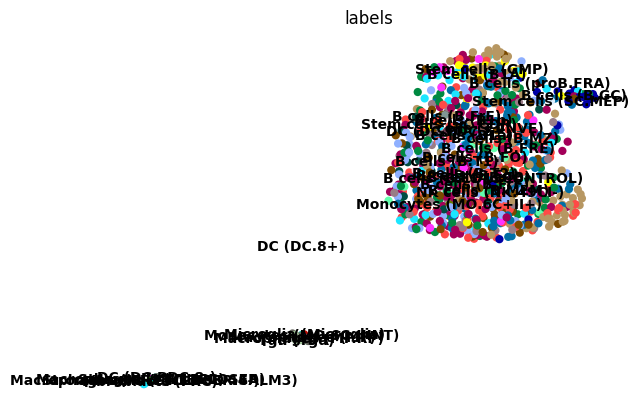

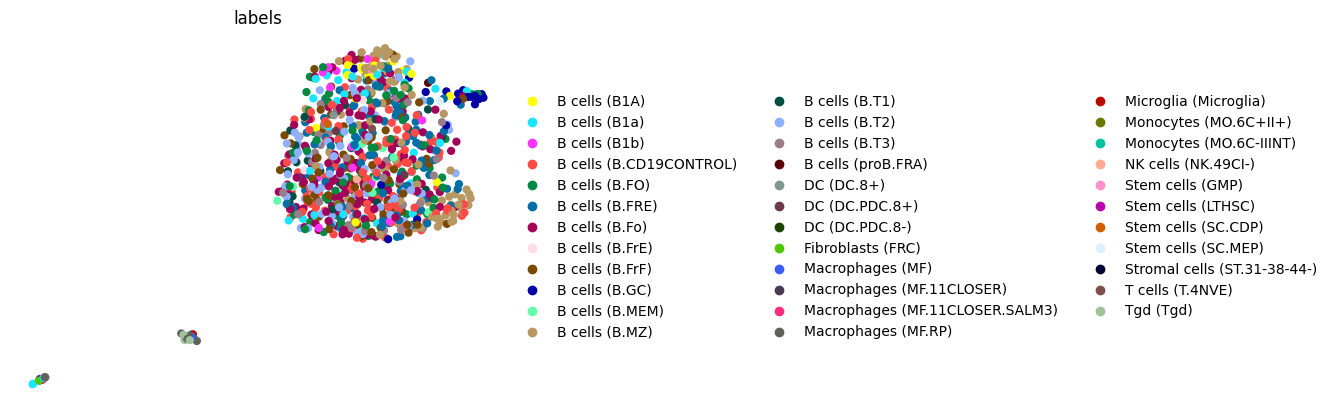

In [ ]:
#Sanity checks
sc.pl.umap(Spleen_data, color=['labels'], frameon=False, legend_loc='on data')
sc.pl.umap(Spleen_data, color=['labels'], frameon=False)

In [ ]:
# Assuming "seurat_clusters" is the column name you want to convert
numeric_col = Spleen_data.obs["seurat_clusters"]
categorical_col = pd.Categorical(numeric_col)

# Assign the new categorical column back to the AnnData object
Spleen_data.obs["seurat_clusters"] = categorical_col

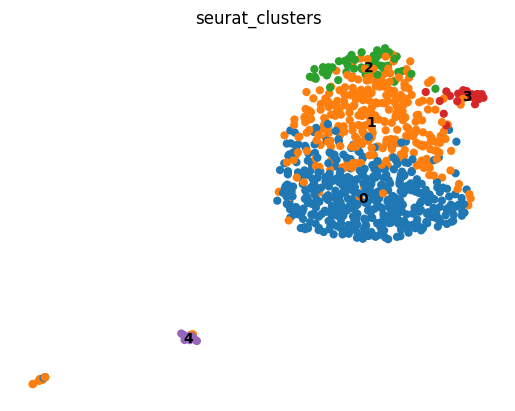

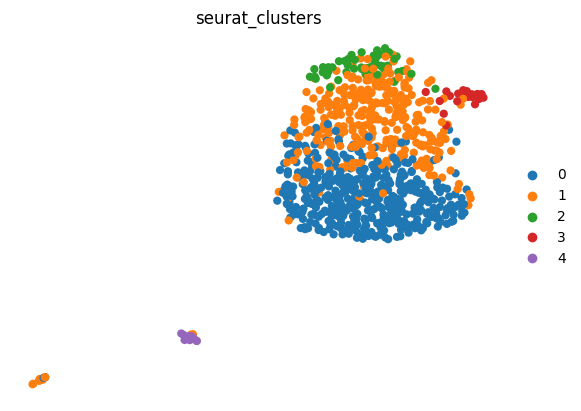

In [ ]:
sc.pl.umap(Spleen_data, color=['seurat_clusters'], frameon=False, legend_loc='on data')
sc.pl.umap(Spleen_data, color=['seurat_clusters'], frameon=False)

In [ ]:
Spleen_data.write('Spleen_data.h5ad')

6. SingleR for cell identification

7. SCORPIUS for linear trajectory

In [ ]:
%R
library(Seurat)
library(SeuratDisk)
library(patchwork)
library(tidyverse)
library(tidyseurat)
library(gridExtra)
library(Matrix)
library(sctransform)
library(data.table)
library(SingleR)

In [ ]:
%R
file.dir <- "/path/to/objects/"
files.set <- list.files(path = file.dir)


sc.list <- list()
for (i in 1:length(files.set)) {

  # load in Seurat object
  object <- LoadH5Seurat(file = paste0(file.dir, files.set[i]), assays = "RNA")
  dataset_name <- gsub(".h5Seurat", "", files.set[i])
  object$dataset <- dataset_name
  object$dataset<-substr(object$dataset, 1,9)
  # Rename cells to avoid future conflicts
  object <- RenameCells(object = object, add.cell.id = dataset_name)


  # process meatadata
  object$sample <- rownames(object@meta.data)
  object@meta.data <- separate(object@meta.data, col = 'sample',
                               into = c('Patient', 'Barcode'), ##here we need our metadata from our files
                               sep = "_")
  object@meta.data <- object@meta.data %>%
    mutate(Status = case_when(
      grepl("C", Patient) ~ "Control",
      grepl("SLE", Patient) ~ "Lupus"
    ))
  object$mitoPercent <- PercentageFeatureSet(object, pattern='^MT-')
  object <- subset(object, subset = nCount_RNA > 800 &
                     nFeature_RNA > 500 &
                     nFeature_RNA < 6000 &
                     mitoPercent < 10)
  # objectfiltered <- SCTransform(objectfiltered, vars.to.regress = "mitoPercent", verbose = F)

  # basic preprocessing

  object <- SCTransform(object, vst.flavor = "v2", verbose = F) %>%
    RunPCA(npcs = 30, verbose = F) %>%
    RunUMAP(reduction = "pca", dims = 1:30, verbose = F) %>%
    FindNeighbors(reduction = "pca", dims = 1:30, verbose = F) %>%
    FindClusters(resolution = 0.7, verbose = F)

  # calculate leverage score and sample 5000 cells based on leverage score
  # atoms.i <- LeverageScoreSampling(object = object, num.cells = 5000)
  sc.list[[i]] <- object
  # delete full object from memory note that this is optional, if you can store the full
  # datasets in memory, you dont have to reload them later
  rm(object)
}


features <- SelectIntegrationFeatures(object.list = sc.list, nfeatures = 3000)
sc.list <- PrepSCTIntegration(object.list = sc.list, anchor.features = features)

sc.anchors <- FindIntegrationAnchors(object.list = sc.list, normalization.method = "SCT",
                                         anchor.features = features)
combined.sct <- IntegrateData(anchorset = sc.anchors, normalization.method = "SCT")

In [ ]:
%R
combined.sct <- RunPCA(combined.sct, verbose = T)
combined.sct <- RunUMAP(combined.sct, reduction = "pca", dims = 1:30, verbose = T)
combined.sct <- FindNeighbors(combined.sct, reduction = "pca", dims = 1:30)
combined.sct <- FindClusters(combined.sct, resolution = 0.3)

DimPlot(lupus.combined.sct, group.by = "dataset")

In [ ]:
%R
blueprint <- celldex::NovershternHematopoieticData()
cell_type_df <-
  GetAssayData(combined.sct, slot = 'counts', assay = "SCT") %>%
  log1p() %>%
  Matrix::Matrix(sparse = TRUE) %>%
  SingleR::SingleR(
    ref = blueprint,
    labels = blueprint$label.main, ##We want the exhaustive list, thus $label.fine instead of $label.main
    method = "single"
  ) %>%
  as.data.frame() %>%
  as_tibble(rownames = "cell") %>%
  dplyr::select(cell, labels)


# Join UMAP and cell type info
combined.sct <-
  combined.sct %>%
  left_join(cell_type_df, by = "cell")
# Reorder columns
combined.sct %>%
  tidyseurat::select(cell, labels, everything())
combined.sct %>%
  ggplot(aes(UMAP_1, UMAP_2, UMAP_3, color = labels)) +
  geom_point()
combined.sct %>%
  ggplot(aes(UMAP_1, UMAP_2, UMAP_3, color = seurat_clusters)) +
  geom_point()
DimPlot(combined.sct, group.by = "labels", label = T)

saveRDS(combined.sct, file = "lupus_combined_sct_annot.rds")

In [ ]:
%R
trajobj <- combined.sct
library(Seurat)
library(SeuratDisk)
library(patchwork)
library(tidyverse)
library(ggplot2)
space <- Embeddings(trajobj, reduction = "pca")

expression <- t(as.matrix(trajobj@assays$SCT@data))
seuratclusters <- trajobj@active.ident
# predicted <- trajobj@meta.data$labels.y
# predicted <- as.factor(predicted)


library(SCORPIUS)
#Calculate Trajectory Inference
draw_trajectory_plot(space, progression_group = seuratclusters, contour = FALSE)
traj <- infer_trajectory(space)
draw_trajectory_plot(
  space,
  progression_group = seuratclusters,
  path = traj$path,
  contour = FALSE
)+ggtitle("Cells Trajectory")
# draw_trajectory_plot(
#   space,
#   progression_group = predicted,
#   path = traj$path,
#   contour = FALSE
# )+ggtitle("B Cells Lupus Trajectory")

# dif. expressed genes
gimp <- gene_importances(expression, traj$time, num_permutations = 0, num_threads = 12)
gene_sel <- gimp[1:50,]
expr_sel <- expression[,gene_sel$gene]
# expr_sel_test <- expression[,c("IGHD")]

modules <- extract_modules(scale_quantile(expr_sel), traj$time, verbose = FALSE)
draw_trajectory_heatmap(expr_sel, traj$time, seuratclusters, show_labels_row = T, fontsize_row=6, modules)


# reverse trajectory if needed
rever <- reverse_trajectory(traj)

draw_trajectory_plot(
  space,
  progression_group = seuratclusters,
  path = rever$path,
  contour = FALSE
)+ggtitle("Cells Trajectory")

gimp <- gene_importances(expression, rever$time, num_permutations = 0, num_threads = 12)
gene_sel <- gimp[1:50,]
expr_sel <- expression[,gene_sel$gene]

modules <- extract_modules(scale_quantile(expr_sel), rever$time, verbose = FALSE)

draw_trajectory_heatmap(expr_sel, rever$time, seuratclusters, modules, show_labels_row = TRUE, fontsize_row=6)

write.csv(modules, "modules.csv")

p1<-DimPlot(combined.sct, group.by = "dataset", reduction = "pca")
p2<-draw_trajectory_plot(
  space,
  progression_group = predicted,
  path = rever$path,
  contour = FALSE
)
p1 | p2

8. SCPA for Pathway Enrichment

In [ ]:
%R
library(SCPA)
library(Seurat)
library(tidyverse)
library(ComplexHeatmap)
library(circlize)
library(magrittr)

lupus <- lupine_harmony_annot
Idents(lupus) <- lupus$labels

DimPlot(lupus, label = T, group.by = "labels", split.by = "Status", raster = FALSE) +
  theme(aspect.ratio = 1)

idents <- c("NK cells", "CD8+ T cells", "NK T cells", "CD4+ T cells", "B cells", "Basophils",
            "Megakaryocytes", "Granulocytes", "Monocytes", "Dendritic cells")

lupus <- subset(lupus, idents = idents)

pathways <- msigdbr("Homo sapiens", "C2", "CP:WIKIPATHWAYS") %>%
  format_pathways()

cell_types <- unique(lupus$labels)
lupus<- SplitObject(lupus, split.by = "Status")

scpa_out <- list()
for (i in cell_types) {

  healthy <- seurat_extract(lupus$Control,
                            meta1 = "labels", value_meta1 = i)

  sle <- seurat_extract(lupus$Lupus,
                          meta1 = "labels", value_meta1 = i)

  print(paste("comparing", i))
  scpa_out[[i]] <- compare_pathways(list(healthy, sle), pathways, parallel = TRUE, cores=10) %>%
    dplyr::select(Pathway, qval) %>%
    set_colnames(c("Pathway", paste(i, "qval", sep = "_")))

  # For faster analysis with parallel processing, use 'parallel = TRUE' and 'cores = x' arguments

}


scpa_out <- scpa_out %>%
  reduce(full_join, by = "Pathway") %>%
  set_colnames(gsub(colnames(.), pattern = " ", replacement = "_")) %>%
  dplyr::select(c("Pathway", grep("qval", colnames(.)))) %>%
  filter_all(any_vars(. > 2)) %>%
  column_to_rownames("Pathway")


col_hm <- colorRamp2(colors = c("blue", "white", "red"), breaks = c(0, 3, 6))


input <- as.matrix(scpa_out)
ComplexHeatmap::Heatmap(input,
        col = col_hm,
        name = "Qval",
        show_row_names = T,
        row_names_gp = gpar(fontsize = 2),
        #right_annotation = row_an, #this is relevant only if you need specific pathways
        column_names_gp = gpar(fontsize = 8),
        border = T,
        column_km = 3,
        row_km = 3,
        column_labels = gsub("_qval", '', colnames(scpa_out))) #check input column names for correct row
